In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler

In [2]:
df_long = pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(432)', header=3, index_col=0, skiprows=range(4,5))
df_short= pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(122)', header=3, index_col=0, skiprows=range(4,5))

In [3]:
def mae(y,yh):
    return np.mean(np.abs(y-yh))

In [4]:
df_train, df_test = df_long.iloc[:315,:], df_short
y_train, date_train = df_train.pop('bp').values, df_train.pop('Date').values
y_test, date_test = df_test.pop('bp').values, df_test.pop('Date')

In [5]:
class TVRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, exog):
        exog = sm.add_constant(exog)

        super(TVRegression, self).__init__(
            endog=y_t, exog=exog, k_states=exog.shape[1]
        )
        # initialization="diffuse" -> When assume no prior knowledge of the state and state_cov

        self.ssm["design"] = exog.T[np.newaxis, :, :]  # shaped 1 x k_states x nobs
        self.ssm["selection"] = np.eye(self.k_states)
        self.ssm["transition"] = np.eye(self.k_states)
        self.k_exog = self.k_states 
        
        # Initialize using known distribution
        # When use the state_cov by OLS (res.normalized_cov_params), the variances are very small,
        # leading the model to rely on this initial estimate too much, thus causes overfitting.
        # As a work around, use the initial state estimate, but increase its covariance matrix by value.
        res = sm.OLS(self.endog, self.exog).fit()
        self.initialize_known(initial_state=res.params[:], initial_state_cov=np.diag([5]*self.k_states))

        # Which parameters need to be positive?
        # Positive constraint setting is very important.
        # MAKE SURE the LENGTH is CORRECT.
        self.positive_parameters = slice(0, self.k_states+2)

    @property
    def param_names(self):
        return ["epsilon"] + ['var.p' + str(i) for i in range(self.k_states)]

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """
        # exog = sm.add_constant(self.exog)
        exog = self.exog
        res = sm.OLS(self.endog, exog).fit()
        params = np.r_[res.scale, [0.01]*(self.k_exog)]
        return params

    def transform_params(self, unconstrained):
        """
        We constraint the variances to be positive
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = (
            constrained[self.positive_parameters] ** 2
        )
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = (
            unconstrained[self.positive_parameters] ** 0.5
        )
        return unconstrained

    def update(self, params, **kwargs):
        params = super(TVRegression, self).update(params, **kwargs)

        
        self["obs_cov", 0, 0] = params[0]
        self["state_cov"] = np.diag(params[1:(self.k_exog+2)])
        
    def clone(self, endog, exog=None, **kwargs):
        return self._clone_from_init_kwds(endog, exog=exog, **kwargs)

In [6]:
num = 12
X_train, X_test = df_train.iloc[:,:num], df_test.iloc[:,:num]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Try some feature selection methods before fitting the Kalman Filter

In [189]:
from skrebate import ReliefF
fs = ReliefF(n_neighbors=10) 
fs.fit(X_train, y_train)
importance = fs.feature_importances_
top_score = fs.top_features_
print(top_score)

[13 40 10 17 37 25 12 27 38  5 34  7  4 36 23 21 41  9 35 33 11 20  1 43
 24  2 28  0 16 19  6 26  8 30 44  3 42 31 14 39 15 32 29 18 22]


In [7]:
mod = TVRegression(y_train, X_train)
res = mod.fit()

# print(res.summary())

In [10]:
res.filtered_state.shape

(13, 315)

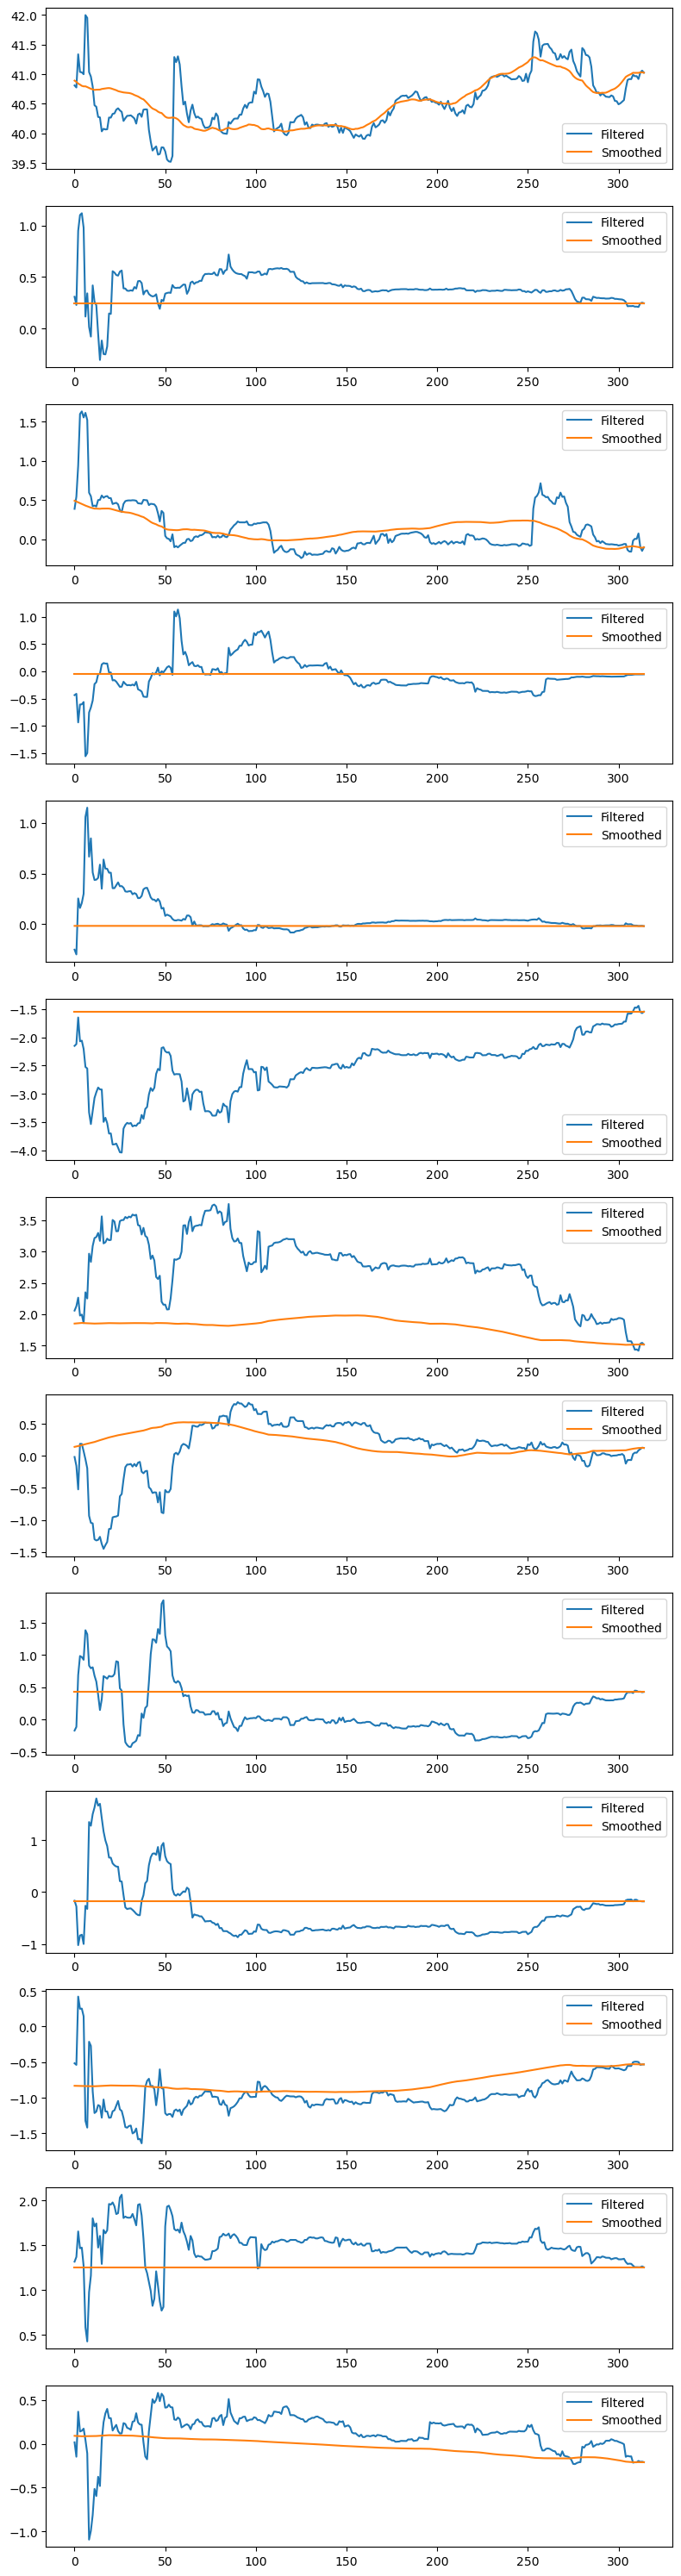

In [13]:
fig, axes = plt.subplots(X_train.shape[1]+1,1,figsize=(8,30))
for i in range(X_train.shape[1]+1):
    axes[i].plot(res.filtered_state[i,:], label='Filtered') # filtered state, theta_i
    axes[i].plot(res.smoothed_state[i,:], label='Smoothed') # smoothed state, theta_i
    axes[i].legend()

plt.tight_layout()

In [23]:
predict = res.get_prediction()
forecasts = res.get_forecast(X_test.shape[0], exog=sm.add_constant(X_test))
# forecasts = res.get_forecast(X_test.shape[0], exog=X_test)

ytrhat = predict.predicted_mean
ytehat = forecasts.predicted_mean
print("Train RMSE: %.4f \nTrain MAE: %.4f" % (rmse(y_train,ytrhat),mae(y_train,ytrhat)))
print("Test RMSE: %.4f \nTest MAE: %.4f" % (rmse(y_test,ytehat),mae(y_test,ytehat)))

Train RMSE: 1.0279 
Train MAE: 0.7470
Test RMSE: 1.3495 
Test MAE: 1.0259


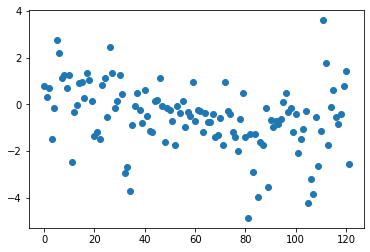

In [185]:
plt.scatter(np.arange(len(y_test)), ytehat-y_test)

In [27]:
# Forecasts using append
forecast_append = pd.DataFrame()
X_test_c = sm.add_constant(X_test)
forecast_append = pd.concat((forecast_append, res.get_forecast(1, exog=X_test_c[0,:]).summary_frame()))
for i in range (len(y_test)-1):
    append_res = res.append(endog=y_test[i:i+1], exog=X_test_c[i:i+1,:], refit=True)
    # append_res = res.extend(endog=y_test[i:i+1], exog=X_test_c[i:i+1,:])
    forecast_append = pd.concat((forecast_append, append_res.get_forecast(1, exog=X_test_c[i+1,:]).summary_frame()))
# print(forecast_append)

In [28]:
ytrhat = predict.predicted_mean
ytehat = forecast_append['mean']
print("Train RMSE: %.4f \nTrain MAE: %.4f" % (rmse(y_train,ytrhat),mae(y_train,ytrhat)))
print("Test RMSE: %.4f \nTest MAE: %.4f" % (rmse(y_test,ytehat),mae(y_test,ytehat)))

Train RMSE: 1.0279 
Train MAE: 0.7470
Test RMSE: 1.2540 
Test MAE: 0.9254


[Text(0, 0.5, 'Boiling point')]

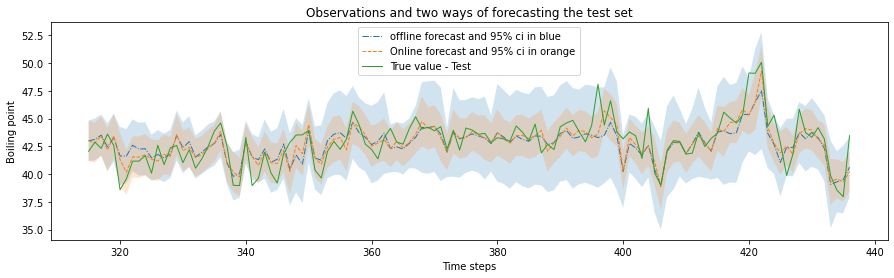

In [109]:
fig, ax = plt.subplots(figsize=(15,4))

predict = res.get_prediction()
# ax.plot(y_train, label='True value - Train', linewidth=1)
# ax.plot(predict.predicted_mean, label='One-step-ahead Prediction and 95% ci in blue', linewidth=1)
# predict_ci = predict.conf_int(alpha=0.05)
# predict_index = np.arange(len(predict_ci))
# ax.fill_between(predict_index[2:], predict_ci[2:, 0], predict_ci[2:, 1], alpha=0.2)
# ax.set(ylim=(30, 58), xlim=(-4, 319))

# len(predict_ci), len(predict_ci) + 
forecast_ci = forecasts.conf_int()
forecast_index = np.arange(len(predict_ci), len(predict_ci) + len(forecast_ci))
ax.plot(forecast_index, forecasts.predicted_mean, '-.', label='offline forecast and 95% ci in blue', linewidth=1)
ax.fill_between(forecast_index, forecast_ci[:, 0], forecast_ci[:, 1], alpha=0.2)


ax.plot(forecast_index, forecast_append['mean'], '--', label='Online forecast and 95% ci in orange', linewidth=1)
ax.fill_between(forecast_index, forecast_append['mean_ci_lower'], forecast_append['mean_ci_upper'], alpha=0.2)

ax.plot(forecast_index, y_test,  label='True value - Test', linewidth=1)

ax.legend(loc='upper center')
# ax.set(title='Fitted values and observations of the training set')
ax.set(title='Observations and two ways of forecasting the test set')
ax.set(xlabel='Time steps')
ax.set(ylabel='Boiling point')

C:\Users\liuwe\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


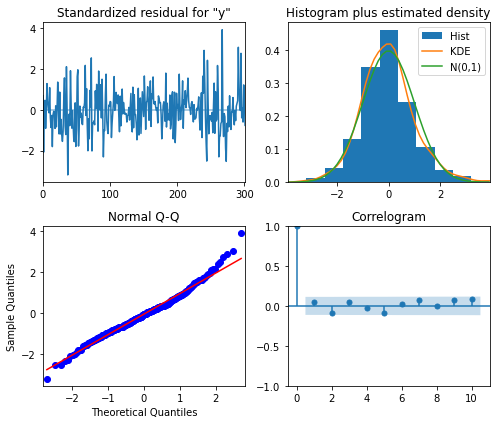

In [125]:
res.plot_diagnostics(figsize=(7,6))
plt.tight_layout();

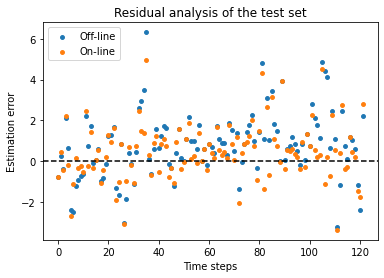

In [177]:
plt.scatter(np.arange(len(y_test)), y_test-forecasts.predicted_mean, label='Off-line', s=15)
plt.scatter(np.arange(len(y_test)), y_test-forecast_append['mean'], label='On-line', s=15)
plt.axhline(0, 0, 120, linestyle = '--', color='k')
plt.title('Residual analysis of the test set')
plt.xlabel('Time steps')
plt.ylabel('Estimation error')
plt.legend(loc='upper left')

In [175]:
# Observability check
# rank[X, X^2, ..., X^12] = 12
X_train_con = sm.add_constant(X_train).T
Observa_matrix = np.tile(X_train_con, 22)
print(np.linalg.matrix_rank(Observa_matrix)) # -> 13
# Therefore, observability is satisfied.

22
